# Explainable Online Reinforcement Learning Using Abstract Argumentation

This notebook demonstrates an end-to-end pipeline to train a symbolic agent (SA) to solve a reinforcement learning (RL) task using abstract argumentation (AA) alone. In particualr, the agent will use a value-based argumentation framework (VAF) as its inference engine. The RL task that the SA will solve is a variant of the Frozen Lake game (see Gym environments) that we called Foggy Frozen Lake (FFL), where the player can observe the surrounding tiles and the index of the tile it is at.

In [197]:
import gym
from gym.envs.toy_text.frozen_lake  import generate_random_map
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm
from datetime import datetime

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

from environments.frozen_lake.frozen_lake import FrozenLakeWrapper, FrozenLakeObservationWrapper, FrozenLakeRewardWrapper
from environments.frozen_lake.utils import FLActions, fl_observation_to_premises, fl_premises_to_args, arg_actions_naive, arg_actions_advanced3, fl_map_to_str, fl_plot_run
from environments.co_aa.co_aa import COAAenv
from agents.co_aa_agent import COAAAgent
from agents.frozen_lake_agent import FLAAAgent

from argumentation.classes import ArgumentationFramework, ValuebasedArgumentationFramework
from argumentation.utils import construct_all_attacks

from utils import update_average, run_episode, new_fl_env
 
np.random.seed(42)

## The Foggy Frozen Lake game ❄

### The map ➡🔳🔳🔳🏁

In [198]:
map_size = 8
prob_frozen = 0.7
game = new_fl_env(map_size, prob_frozen)
map = fl_map_to_str(game.desc)
print("This is what a FFL map looks like: \n\n", map)


This is what a FFL map looks like: 

 [['S' 'F' 'F' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'H' 'H' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'H' 'F']
 ['F' 'F' 'H' 'F' 'F' 'H' 'F' 'H']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'H' 'F' 'F' 'F' 'H' 'H']
 ['F' 'F' 'H' 'F' 'F' 'F' 'F' 'G']]


### Let's watch a gameplay 📺
For now, we will solve this map manually and render each frame of the game.
At the end of this notebook, we will learn to train the symbolic agent solve the FFL game for us.

In [199]:
# Reset the game.
current_state = game.reset()

# Track the rendering
animation_data = []

def game_step(current_action):
    """Auxiliary function to take one step in the game and record the animation data."""
    global total_reward
    global current_state
    next_state, reward, done, _ = game.step(current_action)
    total_reward += reward
    animation_data.append((current_state, next_state, game.t-1, current_action, total_reward))
    current_state = next_state
    return next_state, reward, done, _

# This is a combination of actions that solves this map.
# Replace/add/remove the actions you want to perform on the game.
total_reward = 0
next_state, _, _, _ = game_step(FLActions.DOWN)
next_state, _, _, _ = game_step(FLActions.DOWN)
next_state, _, _, _ = game_step(FLActions.RIGHT)
next_state, _, _, _ = game_step(FLActions.DOWN)
next_state, _, _, _ = game_step(FLActions.DOWN)
next_state, _, _, _ = game_step(FLActions.RIGHT)
next_state, _, _, _ = game_step(FLActions.DOWN)
next_state, _, _, _ = game_step(FLActions.RIGHT)
next_state, _, _, _ = game_step(FLActions.RIGHT)
next_state, _, _, _ = game_step(FLActions.RIGHT)
next_state, _, _, _ = game_step(FLActions.DOWN)
next_state, _, _, _ = game_step(FLActions.DOWN)
next_state, _, _, _ = game_step(FLActions.RIGHT)
next_state, _, _, _ = game_step(FLActions.RIGHT)

# This is to render the terminal state.
animation_data.append((next_state, 'None', game.t, 'None', 0))

# Let's render the gameplay in text.
# This is useful for inspecting strategies.
sns.set_context("paper")
fl_plot_run(game.desc, *zip(*animation_data))

c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


## The Argumentation Frameworks (AFs) 💬

### Naive AF
The domain expert suggests going Up, Down, Left or Right iff the cell in that direction is safe (U, D, L, R).

Naive AF:
    - arguments:  ['U', 'L', 'R', 'D']
    - attacks:  {('U', 'D'), ('D', 'R'), ('L', 'U'), ('L', 'D'), ('U', 'R'), ('D', 'U'), ('R', 'L'), ('D', 'L'), ('R', 'U'), ('L', 'R'), ('R', 'D'), ('U', 'L')}


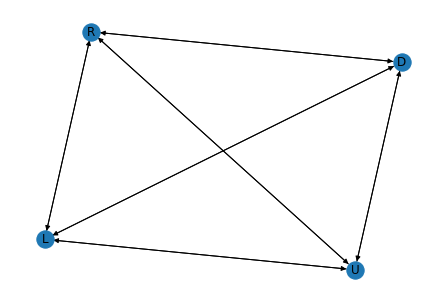

In [154]:
# Get a list with the arguments in the naive AF.
args_naive = list(arg_actions_naive.keys())
print("Naive AF:")
print("    - arguments: ", args_naive)

# Construct all the attacks among arguments.
atts_naive = construct_all_attacks(arg_actions_naive)
print("    - attacks: ", atts_naive)

# Now we can build the AF.
af_naive = ArgumentationFramework(args_naive, atts_naive)

# And visualise it.
af_naive.draw()

### Advanced AF
On top of the previous arguments, the domain expert suggests going Up, Down, Left or Right iff the cell in that direction is safe and has not been visited before (nU, nD, nL, nR).

Advanced AF:
    - arguments:  ['U', 'L', 'R', 'D', 'nD', 'nL', 'nR', 'nU']
    - attacks:  {('D', 'R'), ('nR', 'nU'), ('nL', 'nD'), ('nD', 'L'), ('R', 'nU'), ('D', 'nL'), ('nR', 'nL'), ('U', 'D'), ('L', 'nU'), ('nU', 'R'), ('nL', 'nR'), ('U', 'nR'), ('R', 'nL'), ('nU', 'nL'), ('nD', 'nU'), ('U', 'nD'), ('L', 'R'), ('nL', 'nU'), ('D', 'U'), ('U', 'L'), ('nD', 'R'), ('nL', 'R'), ('D', 'nR'), ('nR', 'U'), ('nR', 'D'), ('nD', 'nL'), ('D', 'L'), ('R', 'U'), ('R', 'D'), ('nU', 'D'), ('nR', 'nD'), ('nU', 'nR'), ('nR', 'L'), ('L', 'U'), ('L', 'D'), ('L', 'nR'), ('U', 'R'), ('R', 'nD'), ('nD', 'U'), ('nL', 'U'), ('R', 'L'), ('nU', 'nD'), ('nL', 'D'), ('nU', 'L'), ('D', 'nU'), ('nD', 'nR'), ('U', 'nL'), ('L', 'nD')}


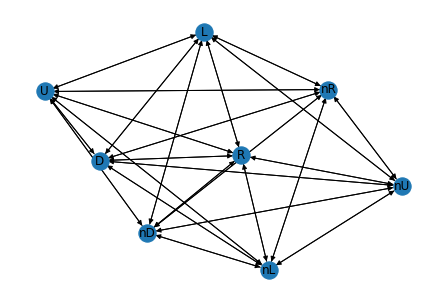

In [162]:
# Let's choose one version of acvanced actions (you can inspect the code for more or come up with your own).
arg_actions_advanced = arg_actions_advanced3

# Get a list with the arguments in the advanced AF.
args_advanced = list(arg_actions_advanced.keys())
print("Advanced AF:")
print("    - arguments: ", args_advanced)

# Construct all the attacks among arguments.
atts_advanced = construct_all_attacks(arg_actions_advanced)
print("    - attacks: ", atts_advanced)

# Now we can build the AF.
af_advanced = ArgumentationFramework(args_advanced, atts_advanced)

# And visualise it.
af_advanced.draw()

## Creating a VAF from an AF
To create a VAF we need a total ordering of the arguments of the input AF, which will be the final outcome of our pipeline. Just to illustrate how a VAF is created and how a symbolic agent can use it to play FFL, one of the optimal solutions found by the pipeline will now be used.

In [156]:
# One of the optimal orders of the advanced AF.
order = ['nR', 'nD', 'L', 'U', 'nL', 'nU', 'D', 'R']
vaf = ValuebasedArgumentationFramework(af_advanced.args, af_advanced.atts, order)

## Instantiating the advanced symbolic agent (SA)
Once a VAF has been created, a SA can be intstantiated to play the game. Each game needs two functions that translate the observations into premises and the premises into arguments.

In [157]:
sa = FLAAAgent(vaf, arg_actions_advanced, fl_observation_to_premises, fl_premises_to_args, map_size)

## Playing FFL 🎮

Let's see if the SA can solve the previous game (the one we solved manually). Fingers crossed 🤞.

In [161]:
# Reset the game.
current_state = game.reset()
# And the SA's memory.
sa.reset_memory()
# Track the rendering
animation_data = []

# Have the agent choose an action until the end of the game is reached.
done = False
total_reward = 0
while done == False:
    next_action = sa.select_action(current_state)
    current_state, _, done, _ = game_step(next_action)

# This is to render the terminal state.
animation_data.append((next_state, 'None', game.t, 'None', 0))

# Let's render the gameplay in text.
# This is useful for inspecting strategies.
sns.set_context("paper")
fl_plot_run(game.desc, *zip(*animation_data))

## Training the SA
So far we have seen how the SA can play the game with an ordering we have provided. To automatically find a good ordering of the arguments, we will translate the task into a combinatorial optimisation (CO) problem that we will solve using RL.

This new CO environment requires the agent to sequentially select the arguments of the AF until creating a total ordering. At the end, the ordering is evaluated in the game and /a reward is emitted. Let's put all this together.

In [170]:
rewards = []
eval = []

vaf_advanced = ValuebasedArgumentationFramework(args_advanced, atts_advanced, [])
aa_agent_advanced = FLAAAgent(vaf_advanced, arg_actions_advanced, fl_observation_to_premises, fl_premises_to_args, map_size)


epsilon = 0.1
gamma = 0.99
alpha = 5e-3
agent_co = COAAAgent(alpha, gamma, epsilon, af_advanced.args)

t_episodes = tqdm(range(1, int(5e3)+1))
for epi in  t_episodes:
    co_env = COAAenv(args_advanced, arg_actions_advanced, af_advanced, new_fl_env(map_size, prob_frozen), fl_observation_to_premises, fl_premises_to_args, aa_agent_advanced)

    agent_co.alpha = np.max([agent_co.alpha*(1-1e-4), 1e-4])
    agent_co.epsilon = np.max([agent_co.epsilon*(1-1e-4), 0.01])
    
    start_state = co_env.reset()
    end_state, total_reward, animation_data = run_episode(co_env, agent_co, start_state, is_learning=True, is_animating=False, is_rendering=False)
    
    rewards.append([epi, total_reward])

    if epi % 100 == 0:
        rew = 0
        N = 10
        for i in range(1, N+1):
            
            vaf = ValuebasedArgumentationFramework(args_advanced, atts_advanced, agent_co.order)
            aa_agent = FLAAAgent(vaf, arg_actions_advanced, fl_observation_to_premises, fl_premises_to_args, map_size)
            co_env = COAAenv(args_advanced, arg_actions_advanced, af_advanced, new_fl_env(map_size, prob_frozen), fl_observation_to_premises, fl_premises_to_args, aa_agent)
            rew += co_env._get_game_reward(False) == 1
        eval.append((epi, (rew/N)*100))

        t_episodes.set_postfix({'avg': np.average([rew[1] for rew in rewards[-100:]]), 'eval': str(eval[-1][1])+'%'})



  0%|          | 0/5000 [00:00<?, ?it/s]

### Inspecting the learning curve

c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


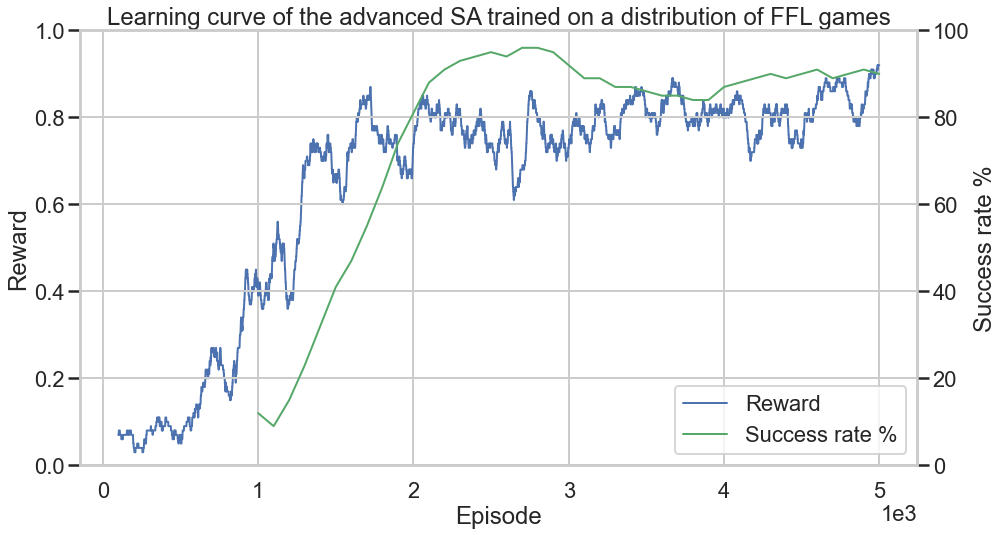

In [182]:
sns.set(rc = {'figure.figsize':(15,8)}, style='whitegrid')
sns.set_context("poster", rc={"lines.linewidth": 2}, font_scale=1)

eval = pd.DataFrame(eval, columns=('episode', 'acc'))
eval['acc_avg'] = eval['acc'].transform(lambda x: x.rolling(10).mean())

rewards = pd.DataFrame(rewards, columns=('episode', 'reward'))
rewards['reward_avg'] = rewards['reward'].transform(lambda x: x.rolling(100).mean())
  
rewards_plot = sns.lineplot(x='episode', y='reward_avg', data=rewards, ci='sd', color="b")
rewards_plot.set(title="Learning curve of the advanced SA trained on a distribution of FFL games")
rewards_plot.set(ylim=(0, 1))
rewards_plot.set(ylabel="Reward")

right_y = rewards_plot.axes.twinx()
sns.lineplot(x='episode', y='acc_avg', data=eval, color="g", ax=right_y, ci='sd')
plt.legend(loc='lower right', handles=[Line2D([], [], marker='_', color="b", label='Reward'), Line2D([], [], marker='_', color="g", label='Success rate %')], facecolor='white')
right_y.set(ylim=(lim*100 for lim in rewards_plot.get_ylim()))
right_y.set(ylabel="Success rate %")

rewards_plot.set(xlabel="Episode")
# rewards_plot.set(xlim=(0, 1e6))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


### The learned ordering

In [186]:
learned_order = agent_co.order
print("Learned ordering:", learned_order)

Learned ordering: ['nR', 'nD', 'L', 'D', 'nL', 'U', 'R', 'nU']


### Evaluating the new ordering
We can now instantiate a new SA that uses the the VAF derived from the learned ordering as its inference engine.

This agent can be evaluated on different games, even coming from a distribution different from the one it saw during the training phase.

In [201]:
# Randomise again the game generation.
np.random.seed()
# Sample a new game.action_space
map_size = 16
prob_frozen = 0.8
game = new_fl_env(map_size, prob_frozen)


# The VAF derived from the learned ordering.
vaf = ValuebasedArgumentationFramework(af_advanced.args, af_advanced.atts, learned_order)
# The corresponding SA.
sa = FLAAAgent(vaf, arg_actions_advanced, fl_observation_to_premises, fl_premises_to_args, map_size)


# Get the initial state
current_state = game.reset()
# Track the rendering
animation_data = []

# Have the agent choose an action until the end of the game is reached.
done = False
total_reward = 0
while done == False:
    next_action = sa.select_action(current_state)
    current_state, _, done, _ = game_step(next_action)

# This is to render the terminal state.
animation_data.append((next_state, 'None', game.t, 'None', 0))

# Let's render the gameplay in text.
# This is useful for inspecting strategies.
sns.set_context("paper")
fl_plot_run(game.desc, *zip(*animation_data))

c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
